#### Antonio Morelli - 0001060348 
# Visual Inspection of Motorcycle Connecting Rods

Students should develop a software system aimed at visual inspection of motorcycle connecting
rods. The system should be able to analyse the dimensions of two different types of connecting rods to allow a vision-guided robot to pick and sort rods based on their type and dimensions. The two rod types are characterized by a different number of holes: Type A rods have one hole whilst Type B rods have two holes.


### First Task

- **Image characteristics**
1. Images contain only connecting rods, which can be of both types and feature significantly diverse dimensions.
2. Connecting rods have been carefully placed within the inspection area so to appear well separated in images (i.e. they do not have any contact point).
3. Images have been taken by the backlighting technique so to render rods easily distinguishable (i.e. much darker) from background. However, for flexibility reasons the system should not require any change to work properly with lighting sources of different power. 

Two exemplar working images are provided below:

![1](./images/1.png "")

- **Functional specifications**

For each connecting rod appearing in the image, the vision system should provide the following
information:
1. Type of rod (A or B).                                            
2. Position and orientation (modulo $\pi$).
3. Length (L), Width (W), Width at the barycenter (WB).
4. For each hole, position of the centre and diameter size.

## Code
### Functions

In [1]:
import cv2
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib import colors as cls
import random
import logging
from itertools import combinations

all_colors = ['#FF3D00', '#B2DFDB', '#F8BBD0', '#7E57C2', '#FF8A65', \
         '#FB8C00', '#A7FFEB', '#B39DDB', '#1E88E5', '#CDDC39']

header_csv = ['filename', 'id', 'type', 'MER', 'centre', 'width', 'length',\
'centre_w', 'theta','color', 'hole_1_centre','hole_1_d_1','hole_1_d_2',\
'hole_2_centre','hole_2_d_1','hole_2_d_2']

# ------------------------------------------------------------------------------
# Save analysis as .csv.
# ------------------------------------------------------------------------------
def save_csv(filename, rods_csv, header):
    df = pd.DataFrame(rods_csv, columns = header)
    df.to_csv(filename, sep = ';', index=False)

    return df

# ------------------------------------------------------------------------------
# Plot a grid containing images to be analyzed.
# ------------------------------------------------------------------------------
def plot_grid(folder):
    plt.figure(figsize=(15, 10))
    idx = 0

    filenames = os.listdir(folder)
    for filename in filenames:
        ax = plt.subplot(3, 3, idx + 1)

        if folder == 'inputs/1':
            ax.set_title(f"Image: {filename}")
        elif folder == 'inputs/2':
            if int(filename[4:6]) < 50:
                ax.set_title(f"Image: {filename} - Other objects")
            elif int(filename[4:6]) < 52:
                ax.set_title(f"Image: {filename} - Contact points")
            else:
                ax.set_title(f"Image: {filename} - Iron powder")
        idx += 1    

        
        img = cv2.imread(os.path.join(folder,filename),0)
        plt.imshow(img, cmap = 'gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# ------------------------------------------------------------------------------
# Plot the results of an analysis and eventually saves the figures.
# ------------------------------------------------------------------------------
def plot_results(filename, img, thresh, output, numRods, numHoles, patches, labels, save = True):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))   

    l1 = ax1.imshow(img,cmap = 'gray')
    ax1.set_title('Image: ' + filename), ax1.set_xticks([]), ax1.set_yticks([])

    l2 = ax2.imshow(255 - thresh,cmap = 'gray')
    ax2.set_title('Otsu'), ax2.set_xticks([]), ax2.set_yticks([])

    l3 = ax3.imshow(output,cmap = 'gray')
    ax3.set_title('Output'), ax3.set_xticks([]), ax3.set_yticks([])

    plt.ylabel('Rods:' + numRods + \
               ' - Holes:' + numHoles, fontweight = 'bold')

    ax3.legend(handles=patches, labels = labels)
    
    if save:
        extent = ax3.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(os.path.join('outputs', filename.split('.')[0]+'.png'),\
                    bbox_inches=extent.expanded(1,.44))

# ------------------------------------------------------------------------------
# Apply median blur of kernel size 'k_s' to 'img'.
# ------------------------------------------------------------------------------
def smoothing(img, k_s):
    return cv2.medianBlur(img, k_s)

# ------------------------------------------------------------------------------
# Returns a hole object that contains the ellipse fitting the component, its
# list of countours point, its orientation, its centre coordinates and
# its diameters. 
# At the very beginning, i was trying to found the minimum enclosing circle of the contour,
# but it soon emerged that ellipses fit better the holes.
# ------------------------------------------------------------------------------
def hole_creation(component, rods):
    ellipse = cv2.fitEllipse(component['contour'])
    hole = {
        'ellipse': ellipse,
        'contour': component['contour'],
        'theta': ellipse[2],
        'centre': (round(ellipse[0][0]),round(ellipse[0][1])),
        'minor_diameter': ellipse[1][0],
        'major_diameter': ellipse[1][1]
    }

    for rod in rods:
        if cv2.pointPolygonTest(rod['contour'],hole['ellipse'][0],measureDist = False) == True:
            rod['holes'].append(hole)
            rod['type'] += 1                
            break

# ------------------------------------------------------------------------------
# Returns a rod object that contains its minimum enclosing rectangle, its
# moments values, it barycentre coordinates and width, it list of contours point, 
# its type, its orientation and its color.
# The orientation is computed according to the minimum fitting ellipse, since seemed 
# to give more accurate results. The function's call 'cv2.fitEllipse()[2]' returns
# the orientation wrt to y-axis.
#         https://datascience.stackexchange.com/questions/85064/where-is-the-rotated-angle-actually-located-in-fitellipse-method
# ------------------------------------------------------------------------------
def rod_creation(component, colors, idx_comp, rods, patches):    
    # Mer
    minRect = cv2.minAreaRect(component['contour'])
    # Moments
    moments = cv2.moments(component['contour'])

    # Barycentre
    centre = (round(moments['m10'] / moments['m00']), \
                  round(moments['m01'] / moments['m00']))
        
    rod = {
        'id': idx_comp,
        'contour': component['contour'],
        'type': 0,
        'rect': minRect,
        'cX': centre[0],
        'cY': centre[1],
        'width':  round(minRect[1][0],2),
        'length':  round(minRect[1][1],2),
        'centre_w': round(min([np.linalg.norm(centre-a) for a in component['contour']]),2),
        'color': random.choice(colors),
        'holes': [],
        'M': moments,
        'theta': cv2.fitEllipse(component['contour'])[2]
    }
    colors.remove(rod['color'])
    idx_comp += 1
    rods.append(rod)       
    patches.append(mpatches.Patch(color=cls.to_rgb(rod['color']), label = rod['id']))
    
    return rod

# ------------------------------------------------------------------------------
# Draws axes of a component, either of a rod or an of inside hole. 
# For major axis, this is done by computing the angle value wrt to the horizontal
# axis and drawing an oriented line that goes through the centre; the minor 
# axis is instead drew by rotating the major axis vector of 90° degrees.  
# ------------------------------------------------------------------------------
def draw_axis(component, output, centre, l_minor, h = False):

    (xc, yc), (d1,d2), _ = cv2.fitEllipse(component['contour'])
    angle = component['theta'] - 90 if component['theta'] > 90 else component['theta'] + 90
    
    l_major = max(d1,d2)/2
    
    xtop = xc + np.cos(np.radians(angle))       * l_major
    ytop = yc + np.sin(np.radians(angle))       * l_major
    xbot = xc + np.cos(np.radians(angle+180))   * l_major
    ybot = yc + np.sin(np.radians(angle+180))   * l_major
        
    # Drawing major axis for rods and holes
    if not h:
        cv2.line(output, (round(xtop),round(ytop)), (round(xbot),round(ybot)), (0, 255, 0), 2)
    else:
        cv2.line(output, (round(xtop),round(ytop)), (round(xbot),round(ybot)), (0, 0, 0), 1)
    
    xtop = centre[0] + np.cos(np.radians(angle+90))    * l_minor
    ytop = centre[1] + np.sin(np.radians(angle+90))    * l_minor
    xbot = centre[0] + np.cos(np.radians(angle+270))   * l_minor
    ybot = centre[1] + np.sin(np.radians(angle+270))   * l_minor
    
    # Drawing minor axis for rods and holes
    if not h:
        cv2.line(output, (round(xtop),round(ytop)), (round(xbot),round(ybot)), (0, 255, 0), 2)
                
        # Drawing barycentre
        cv2.circle(output, (centre[0], centre[1]), 5, (255, 255, 255), -1)
        cv2.circle(output, (centre[0], centre[1]), 5, (0, 0, 0), 1)
        cv2.putText(output, text = str(component['id']), org = (centre[0], centre[1]),\
            fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale = 0.6, color = (0,0,0),\
            thickness=2)
        cv2.putText(output, text = str(component['id']), org = (centre[0], centre[1]),\
                fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale = 0.6, color = (255,255,255),\
                    thickness=1)

    else:
        cv2.line(output, (round(xtop),round(ytop)), (round(xbot),round(ybot)), (0, 0, 0), 1) 
        
# ------------------------------------------------------------------------------
# Draws rods and their holes. 
# If debug mode is on, prints rod's features on the console.
# If 'csv' is True, then it also returns the data structure containing rods' features.
# ------------------------------------------------------------------------------
def analysis_output(filename, rods, output, rods_csv, mer = False, csv = True):
    for rod in rods:
        # Rod's type
        if rod['type'] < 2:
            logging.debug(f"\tRod: {rod['id']}-A")
        else:
            logging.debug(f"\tRod: {rod['id']}-B")

        # Filling color
        cv2.drawContours(output,[rod['contour']],-1,\
                 [ch * 256 for ch in list(cls.to_rgb(rod['color']))],thickness = cv2.FILLED)
    
        # Rod's contour
        cv2.drawContours(output,[rod['contour']],-1,\
                 (0,0,0),thickness = 1)

        # Mer
        box = cv2.boxPoints(rod['rect'])            
        box = np.int64(box)
        logging.debug(f"\t\tMER coordinates: {[(round(p[0],2),round(p[1],2))for p in box]}")
        if mer:
            cv2.drawContours(output,[box],-1,(0,0,0),1)

        # Rod's barycentre
        logging.debug(f"\t\tCentroid: ({rod['cX']}) ({rod['cY']})")
    
        # Barycentre's width
        logging.debug(f"\t\tWidth at the barycentre:' {round(rod['centre_w']*2,2)}")

        # Orientation
        logging.debug(f"\t\tTheta wrt y axis: {round(rod['theta'],2)}")
    
        # Length and width are swapped so that lenght represents always the major
        # axis of the object
        length = rod['length'] if rod['length'] > rod['width'] else rod['width']    
        width = rod['width'] if rod['width'] < rod['length'] else rod['length']
    
        logging.debug(f"\t\tWidth: {width} - Length {length}")  

        # Axis and orientation
        draw_axis(rod, output, (rod['cX'],rod['cY']), rod['centre_w'])        
        
        if csv:
            # Creation of the structure that will populate the .csv file
            rod_csv = [filename,rod['id'],'A' if rod['type'] < 2 else 'B',\
                    [(round(p[0],2),round(p[1],2))for p in box],(rod['cX'],rod['cY']),width,length,\
                    rod['centre_w'],round(rod['theta'],2),rod['color']]

        # Holes
        logging.debug(f"\t\tHoles:")
        for id_h,hole in enumerate(rod['holes']):    

            logging.debug(f"\t\t\tHole: {id_h+1}")

            # Hole's barycentre
            logging.debug(f"\t\t\t\tcentre: {hole['centre']}")    
            cv2.circle(output, hole['centre'], 2, (0, 0, 0), -1)

            # Major diameter
            logging.debug(f"\t\t\t\tMajor axis: {round(hole['major_diameter'],2)}")

            # Minor diameter
            logging.debug(f"\t\t\t\tMinor axis: {round(hole['minor_diameter'],2)}")

            # Filling color and contour
            cv2.ellipse(output,hole['ellipse'],(255,255,255),thickness = cv2.FILLED)
            cv2.ellipse(output,hole['ellipse'],(0,0,0),thickness = 1)

            # Axis and radius
            draw_axis(hole, output, hole['centre'], hole['minor_diameter']/2, True)

            if csv:
                rod_csv.append(hole['centre'])
                rod_csv.append(round(hole['major_diameter'],2))
                rod_csv.append(round(hole['minor_diameter'],2))


        # If the analyzed rod has less than two holes inside, append empty values to the data structure
        if csv:
            if rod['type'] < 2:
                rod_csv.append([])
                rod_csv.append(0.)
                rod_csv.append(0.)

            rods_csv.append(rod_csv)     
            
    return rods_csv

# ------------------------------------------------------------------------------
# Here we compute the nth-percentile (default 90) of non zero pixels in a patch 
# around the defects point to threshold the 'deepests' points (i.e. the contacts 
# point between two rods)
# ------------------------------------------------------------------------------
def percentile_nzps(contours, thresh, hierarchy, n):
    nzps = []   
    
    for c in zip(contours, hierarchy):        
        component = {
            'contour': c[0],
            'hierarchy': c[1],
        }
         
        if component['hierarchy'][2] < 0:  
            continue
        elif component['hierarchy'][3] < 0:  
            hull = cv2.convexHull(component['contour'], returnPoints = False)
            defects = cv2.convexityDefects(component['contour'],hull)
                        
            for i in range(defects.shape[0]):
                _,_,f,_ = defects[i,0]
                farthest = tuple(component['contour'][f][0])
                patch = 255-thresh[farthest[1]-5:farthest[1]+5,farthest[0]-5:farthest[0]+5]

                nzps.append(cv2.countNonZero(patch))      
    
    
    percentile = int(np.percentile(nzps, n))

    return percentile

# ------------------------------------------------------------------------------------------------
# Convexity and defects point to separate components. The key idea here is to search for convexity
# defects points of blobs' convex hull.
# A Convex object is one with no interior angles greater than 180 degrees. A shape that is not convex 
# is called Non-Convex or Concave. Hull means the exterior or the shape of the object. 
# Therefore, the Convex Hull of a shape or a group of points is a tight fitting convex boundary 
# around the points or the shape.
# Any deviation of the object from this hull can be considered as convexity defect, so what we do 
# here is find those defects points on the component countour and threshold them according to the number 
# of non zero pixels contained on the negative of the binarized image (i.e., foreground pixels) that lie 
# inside a patch taken around the defect point; it is perceptible visually that a 5x5 patch over those 
# points contains more non zero points than the rest of the possible defects points, so a threshold
# is choosen according to the value of the 90 percentile of the list of defects points ordered by
# the number of non zero points contained in their patches. 
# Source:
#   https://answers.opencv.org/question/87583/detach-blobs-with-a-contact-point/  
# ------------------------------------------------------------------------------------------------
def convexityDefects(img, thresh, contours, hierarchy, perc = 90):    
    th = percentile_nzps(contours, thresh, hierarchy, perc)
    
    for c in zip(contours, hierarchy):        
        component = {
            'contour': c[0],
            'hierarchy': c[1],
        }
         
        if component['hierarchy'][2] < 0:  
            continue
        elif component['hierarchy'][3] < 0:                      
            hull = cv2.convexHull(component['contour'], returnPoints = False)
            defects = cv2.convexityDefects(component['contour'],hull)
                        
            def_points = []
            for i in range(defects.shape[0]):
                _,_,f,_ = defects[i,0]
                farthest = tuple(component['contour'][f][0])
                patch = 255-thresh[farthest[1]-5:farthest[1]+5,farthest[0]-5:farthest[0]+5]

                nzp = cv2.countNonZero(patch)
                if nzp >= th:
                    def_points.append(farthest)
            
            for i in range(int(len(def_points)/2)):
                minimum = min([np.linalg.norm(np.array(p[0])-np.array(p[1]))\
                   for p in list(combinations(def_points,2))])
                p = [p for p in list(combinations(def_points,2)) \
                       if np.linalg.norm(np.array(p[0])-np.array(p[1])) == minimum][0]
                    
                cv2.line(thresh,p[0],p[1],(0,0,0),3)
                cv2.line(thresh,p[0],p[1],(255,255,255),2)    
                cv2.circle(thresh,p[0],2,(255,255,255),-1)    
                cv2.circle(thresh,p[1],2,(255,255,255),-1)    

                cv2.circle(img,p[0],1,(255,255,255),-1)
                cv2.circle(img,p[1],1,(255,255,255),-1)
                
                def_points.remove(p[0])
                def_points.remove(p[1])        
                
    # Finding outer and inner contours after separation
    _ , contours, hierarchy = cv2.findContours(255-thresh\
                                               , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    return img, thresh, contours, hierarchy[0]

# ------------------------------------------------------------------------------------------------
# Analysis to discern rods contours from internal holes contours according to the hierarchy of
# their contours. 
# The 'hierarchy' variable is a three-dimensional NumPy array, with one row, X columns, and 
# a "depth" of 4. The X columns correspond to the number of contours found by the function. 
# The cv2.RETR_TREE parameter causes the function to find the internal contours as well as 
# the outermost contours for each object. Column zero corresponds to the first contour, 
# column one the second, and so on.
# Each of the columns has a four-element array of integers, representing indices of 
# other contours, according to this scheme:
#                             [next, previous, first child, parent]
# Hence, if 'first child' is equal to -1, the countour must belong to an internal hole,
# while, if it has no parent, then it must be the one of a rod.  
# Source:
#   https://stackoverflow.com/questions/11782147/python-opencv-contour-tree-hierarchy-structure
#
# Here we also take in account of possible changes of the characteristics of the working images, 
# respectively the presence of other objects like washers and screws (1), the presence of contact 
# points (2) or the one of iron powder.
# ------------------------------------------------------------------------------------------------
def component_analysis(filename, img, thresh, contours, hierarchy, output, rods_csv,\
                       change, verbose = False, plot = True):  
    if verbose:
        logging.getLogger().setLevel(logging.DEBUG)
    else:
        logging.getLogger().setLevel(logging.CRITICAL)

    # By extracting hierarchy[0] we get the actual inner list of hierarchy descriptions.
    hierarchy = hierarchy[0] 
    idx_comp = 0   
    rods, holes, patches = [],[],[]   
        
    
    # If there are no any contact point
    if change == 2:
        img, thresh, contours, hierarchy = convexityDefects(img, thresh, contours, hierarchy, 90)    
    
    logging.debug(f"Filename: {filename}")
    for c in zip(contours, hierarchy):        
        component = {
            'contour': c[0],
            'hierarchy': c[1],
        }        
        
        # If there is iron powder, then all the  components with a surface greather than a certain threshold
        # are analyzed, while the small powder is not taken in account. 
        # I tried to use morphological operations and a stronger median filter, but it ended in corrupting
        # the shape of some rods' thins circles.
        if change == 3 and cv2.contourArea(component['contour']) <= 50:  
            continue
        
        # If the component is an internal contour (i.e. a hole of the rod), since they do not have children 
        # in the contours hierarchy.
        if component['hierarchy'][2] < 0: 
            # If there are other objects like an elongated screw, they will not have any children in the
            # contours hierarchy too, so we threshold over circularity to avoid their analysis.
            # (A screw has lower circularity than an internal hole)
            if change == 1:
                area = cv2.contourArea(component['contour'])
                perimeter = cv2.arcLength(component['contour'],True)
                circularity = 4 * np.pi * (area / perimeter**2)

                if circularity <= 0.50:
                    continue
            
            hole_creation(component,rods)
        
        # If the component is an external contour (i.e. a rod), since they do not have parents 
        # in the contours hierarchy.       
        elif component['hierarchy'][3] < 0:
            # If there are other objects like a rounded washer, they will not have any parent in the
            # contours hierarchy too, so we threshold over circularity to avoid their analysis.
            # (A washer has higher circularity than a rod)
            if change == 1:
                area = cv2.contourArea(component['contour'])
                perimeter = cv2.arcLength(component['contour'],True)
                circularity = 4 * np.pi * (area / perimeter**2)

                if circularity > 0.85:
                    continue
            rod_creation(component, colors, idx_comp, rods, patches)
            idx_comp += 1   

    # We first find all the rods, then perform the analysis
    rods_csv = analysis_output(filename, rods, output, rods_csv)
    
    # Visual Results    
    if plot:
        numRods = str(len([h for h in hierarchy if h[3] < 0]))
        numHoles = str(len([h for h in hierarchy if h[2] < 0]))
        labels = [str(rod['id'])+'-A' if rod['type'] < 2 else str(rod['id'])+'-B'\
                                                                     for rod in rods]        
        plot_results(filename, img, thresh, output,numRods, numHoles, patches, labels)  

    return rods_csv

### Execution

#### Display

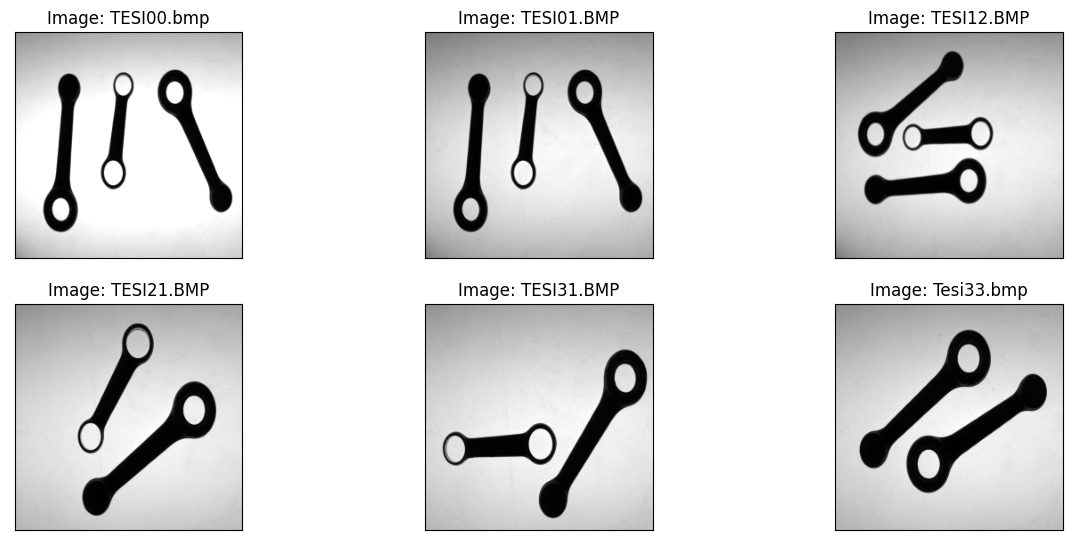

In [2]:
plot_grid('inputs/1')

#### Analysis

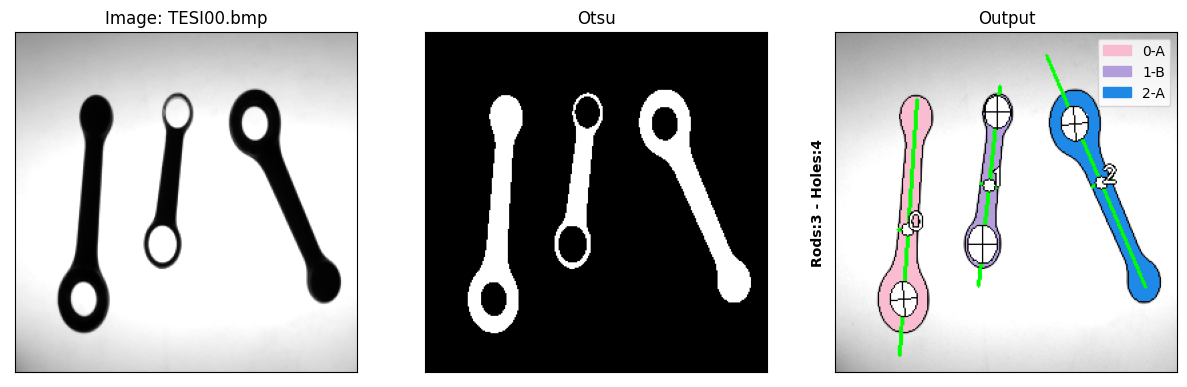

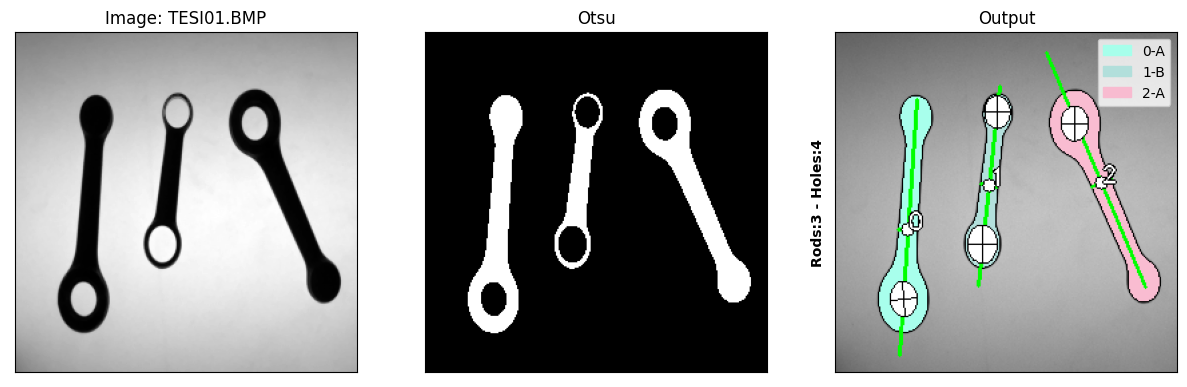

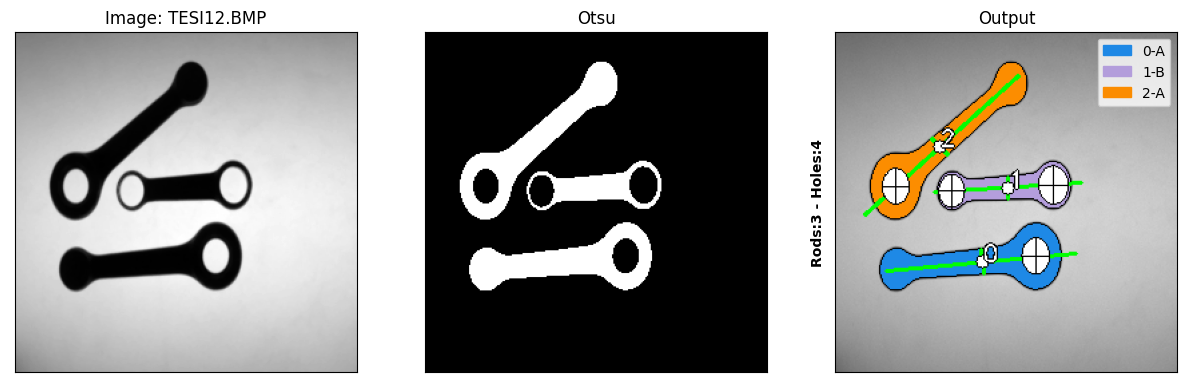

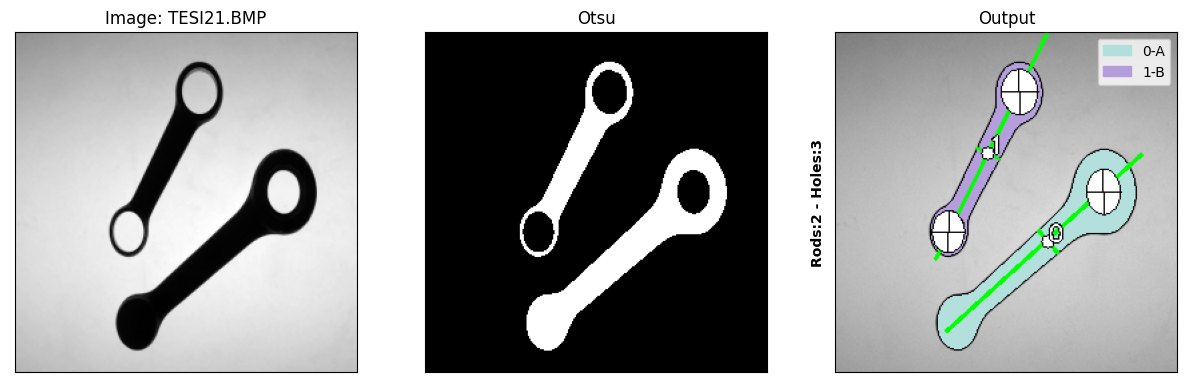

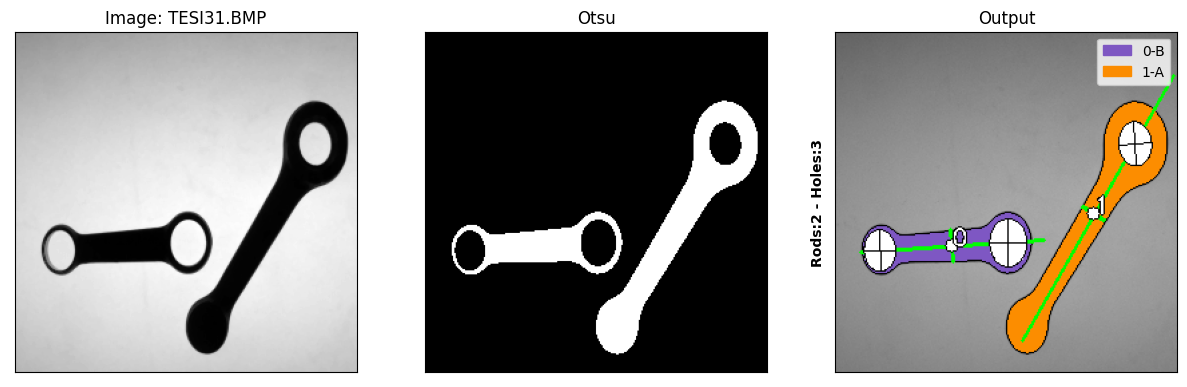

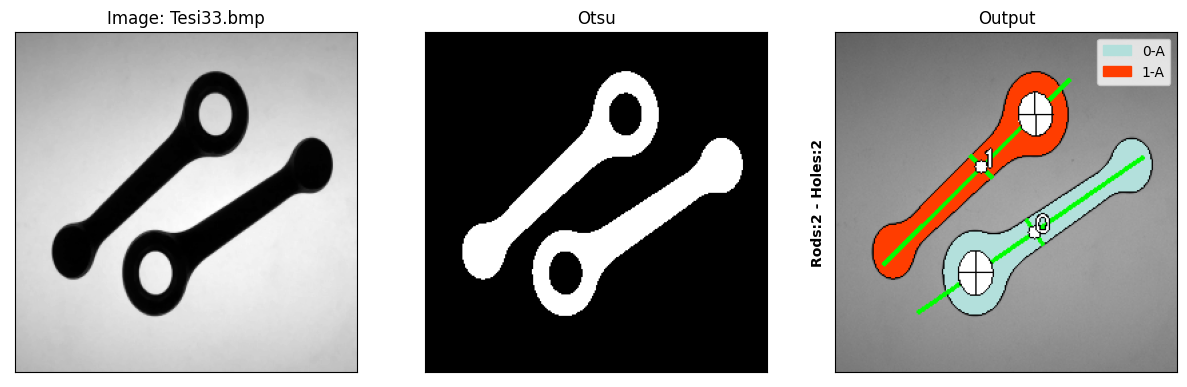

In [3]:
folder = 'inputs/1/'

images, b_images, ccs = [],[],[]
filenames = os.listdir(folder)
rods_csv = []

for idx,filename in enumerate(filenames):    
    img = cv2.imread(os.path.join(folder,filename),0)
        
    output = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)

    colors = all_colors.copy()
    
    # Applying median blur to obtain a better binarization
    img = smoothing(img,3)
    
    # Thresholding with Otsu's method since the system should not 
    # require any change to work properly with lighting sources of different power
    _, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Finding outer and inner contours
    _ , contours, hierarchy = cv2.findContours(255-thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    rods_csv = component_analysis(filename, img, thresh, contours, hierarchy, output, rods_csv, 0)

#### .csv

In [4]:
df = save_csv('task_1.csv', rods_csv, header_csv)

df.iloc[:, 1:].head()

,id,type,MER,centre,width,length,centre_w,theta,color,hole_1_centre,hole_1_d_1,hole_1_d_2,hole_2_centre,hole_2_d_1,hole_2_d_2
0,0,A,"[(68, 225), (31, 224), (35, 47), (72, 48)]","(54, 148)",37.27,177.26,7.00,3.90,#F8BBD0,"(51, 200)",26.54,20.36,[],0.00,0.00
1,1,B,"[(121, 178), (94, 175), (106, 44), (133, 47)]","(115, 115)",26.98,131.73,6.32,6.00,#B39DDB,"(110, 159)",28.80,22.29,"(121, 60)",24.53,19.44
2,2,A,"[(211, 210), (152, 52), (189, 38), (248, 197)]","(199, 113)",39.78,169.35,7.07,157.02,#1E88E5,"(179, 69)",26.26,20.67,[],0.00,0.00
3,0,A,"[(68, 225), (31, 224), (35, 47), (72, 48)]","(54, 148)",37.27,177.26,7.00,3.91,#A7FFEB,"(51, 200)",26.65,20.28,[],0.00,0.00
4,1,B,"[(121, 178), (94, 175), (106, 44), (133, 47)]","(115, 115)",26.99,131.73,6.32,6.03,#B2DFDB,"(110, 159)",28.79,22.37,"(121, 60)",24.54,19.40


### Second Task

While still meeting the requirement of the First Task, students should modify the system in order to deal with one (or more) of the following three changes in the characteristics of the working images:
1. Images may contain other objects (i.e. screws and washers) that need not to be analysed by the system (such kind of objects are often referred to in computer vision as “distractors”).
2. Rods can have contact points but do not overlap one to another.
3. The inspection area may be dirty due to the presence of scattered iron powder.

Exemplar working images corresponding to the three changes are provide below:

![2](./images/2.png "Change 1.")
<center>Change 1.</center>

![3](./images/3.png "Change 2.")
<center>Change 2.</center>

![4](./images/4.png "Change 3.")
<center>Change 3.</center>

## Code

### Display

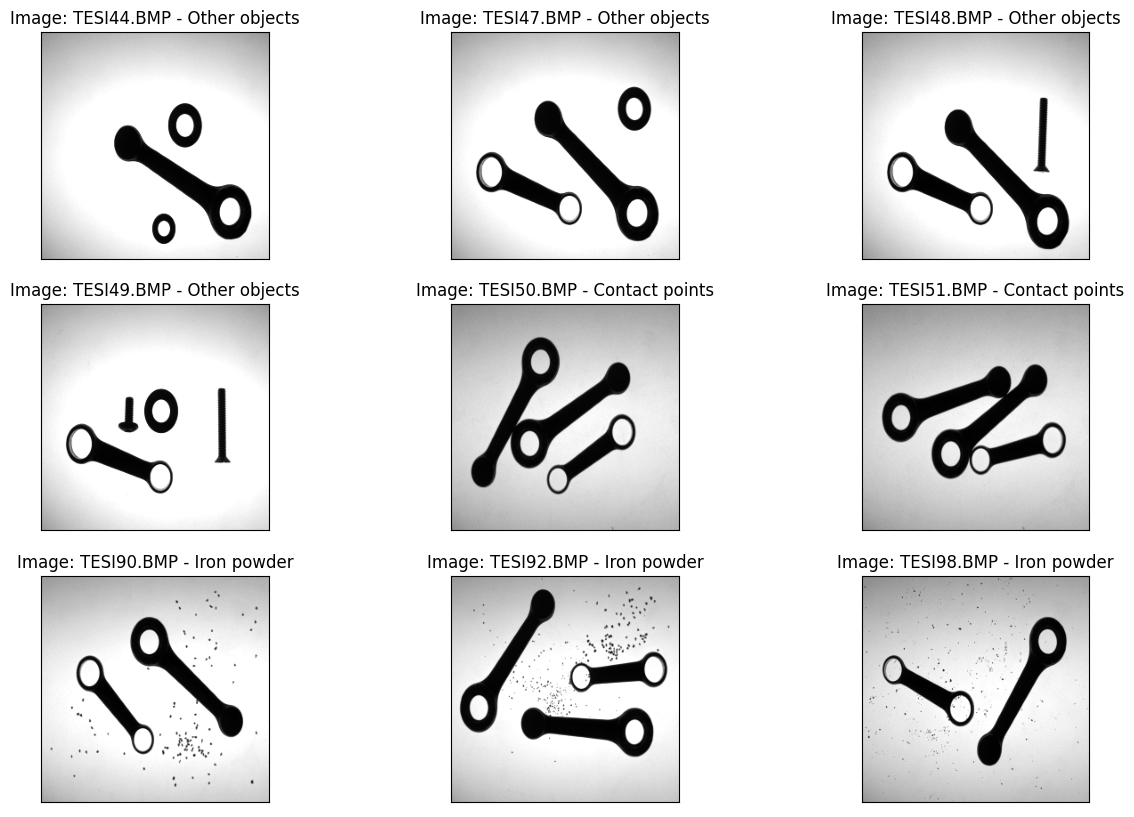

In [5]:
plot_grid('inputs/2')

### Change 1

#### Analysis

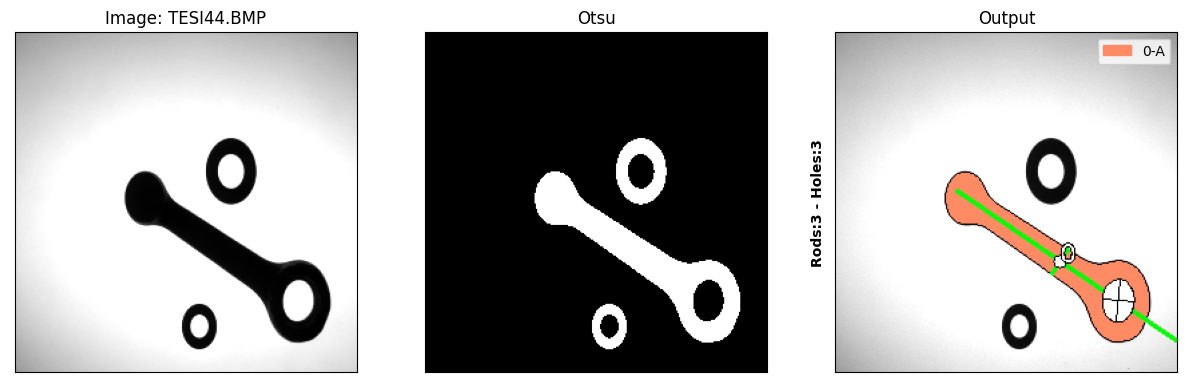

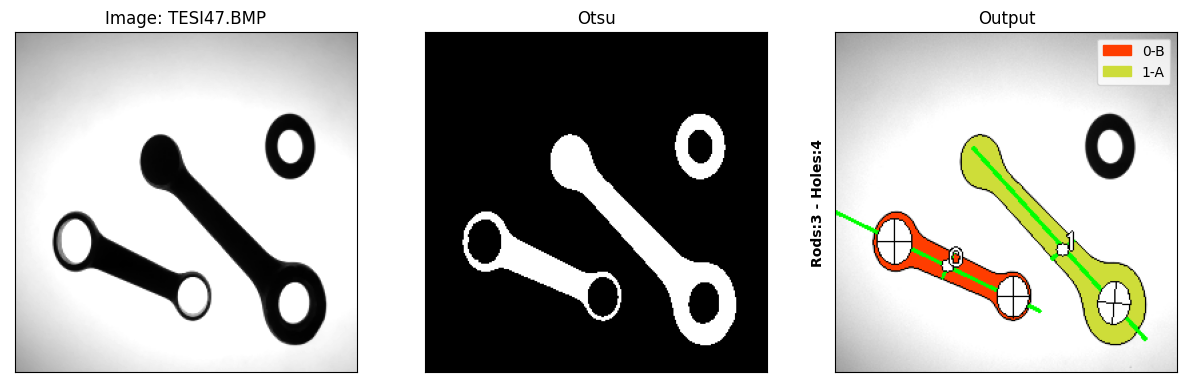

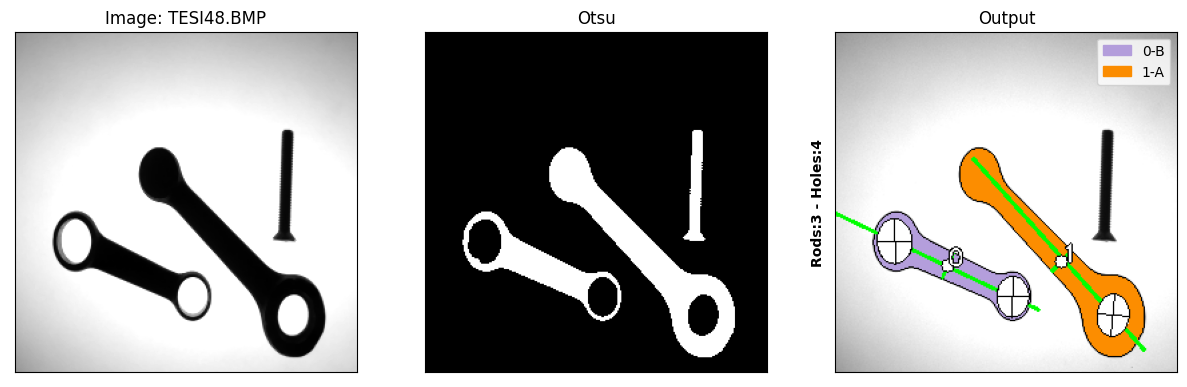

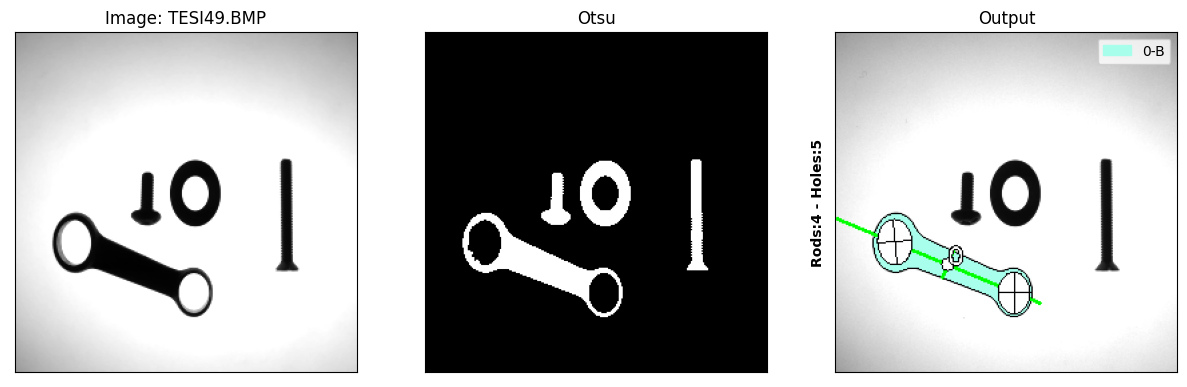

In [6]:
folder = 'inputs/2/'

images, b_images, ccs = [],[],[]
filenames = os.listdir(folder)
filenames = filenames[:4]
rods_csv = []

for idx,filename in enumerate(filenames):    
    img = cv2.imread(os.path.join(folder,filename),0)
    output = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)

    colors = all_colors.copy()

    # Applying median blur to obtain a better binarization
    img = smoothing(img,3)
        
    # Thresholding with Otus's method Since the system should not 
    # require any change to work properly with lighting sources of different power
    _, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Finding outer and inner contours
    _ , contours, hierarchy = cv2.findContours(255-thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    rods_csv = component_analysis(filename, img, thresh, contours, hierarchy, output, rods_csv, 1)

#### .csv

In [7]:
df = save_csv('task_2_c1.csv', rods_csv, header_csv)

df.iloc[:, 1:].head()

,id,type,MER,centre,width,length,centre_w,theta,color,hole_1_centre,hole_1_d_1,hole_1_d_2,hole_2_centre,hole_2_d_1,hole_2_d_2
0,0,A,"[(215, 240), (72, 128), (107, 83), (250, 196)]","(168, 172)",56.54,182.08,10.82,124.28,#FF8A65,"(212, 201)",32.03,24.07,[],0.00,0.00
1,0,B,"[(134, 227), (19, 167), (38, 129), (153, 189)]","(84, 175)",42.85,129.38,10.30,115.51,#FF3D00,"(133, 198)",30.55,23.96,"(44, 157)",33.87,26.38
2,1,A,"[(206, 242), (83, 94), (125, 59), (247, 208)]","(170, 163)",53.45,192.34,10.30,137.83,#CDDC39,"(208, 203)",32.12,24.16,[],0.00,0.00
3,0,B,"[(135, 225), (19, 167), (38, 129), (154, 187)]","(84, 175)",42.49,129.24,10.30,115.43,#B39DDB,"(133, 198)",30.60,24.05,"(44, 157)",33.64,26.42
4,1,A,"[(205, 251), (82, 103), (123, 69), (246, 217)]","(169, 172)",53.51,192.19,9.90,138.07,#FB8C00,"(208, 212)",31.86,24.10,[],0.00,0.00


### Change 2

#### Analysis

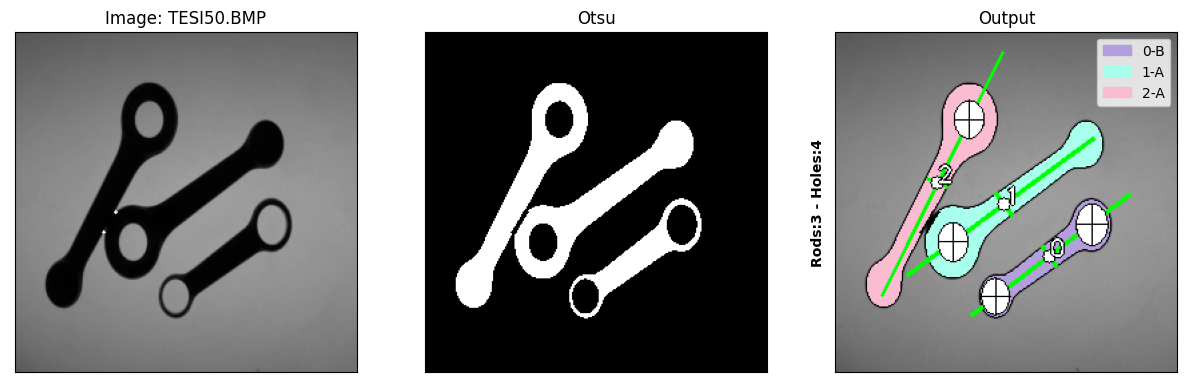

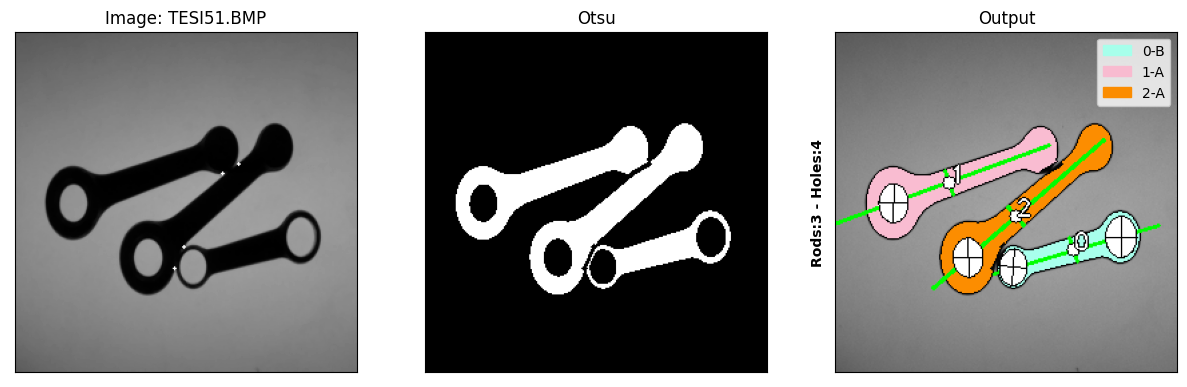

In [8]:
folder = 'inputs/2/'

images, b_images, ccs = [],[],[]
filenames = os.listdir(folder)
filenames = filenames[4:6]
rods_csv = []

for idx,filename in enumerate(filenames):    
    img = cv2.imread(os.path.join(folder,filename),0)
    output = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)

    colors = all_colors.copy()

    # Applying median blur to obtain a better binarization
    img = smoothing(img,3)
        
    # Thresholding with Otus's method Since the system should not 
    # require any change to work properly with lighting sources of different power
    _, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Finding outer and inner contours
    _ , contours, hierarchy = cv2.findContours(255-thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    rods_csv = component_analysis(filename, img, thresh, contours, hierarchy, output, rods_csv, 2) 

#### .csv

In [9]:
df = save_csv('task_2_c2.csv', rods_csv, header_csv)

df.iloc[:, 1:].head()

,id,type,MER,centre,width,length,centre_w,theta,color,hole_1_centre,hole_1_d_1,hole_1_d_2,hole_2_centre,hole_2_d_1,hole_2_d_2
0,0,B,"[(122, 222), (99, 195), (193, 120), (215, 147)]","(160, 168)",35.61,119.94,8.60,52.61,#B39DDB,"(120, 198)",27.31,21.17,"(192, 144)",30.90,23.62
1,1,A,"[(85, 191), (53, 154), (176, 48), (209, 86)]","(126, 129)",49.60,162.48,9.43,53.73,#A7FFEB,"(88, 157)",29.22,22.44,[],0.00,0.00
2,2,A,"[(56, 216), (16, 198), (90, 32), (131, 50)]","(76, 113)",44.32,182.16,7.81,26.53,#F8BBD0,"(100, 66)",28.47,22.26,[],0.00,0.00
3,0,B,"[(127, 201), (115, 164), (221, 130), (233, 166)]","(178, 163)",38.30,111.63,8.94,73.73,#A7FFEB,"(133, 176)",27.67,20.80,"(214, 154)",30.76,23.22
4,1,A,"[(34, 160), (12, 113), (150, 49), (172, 96)]","(85, 113)",52.26,152.66,9.85,69.80,#F8BBD0,"(43, 128)",29.31,21.86,[],0.00,0.00


### Change 3

#### Analysis

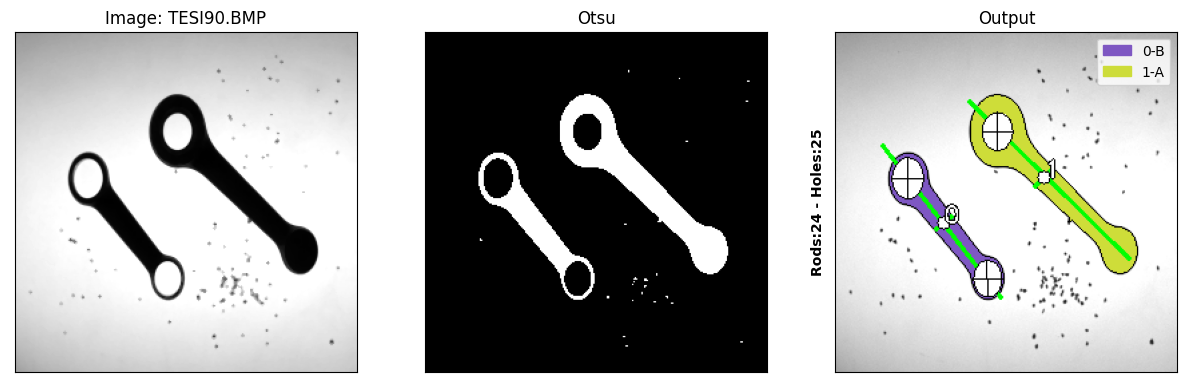

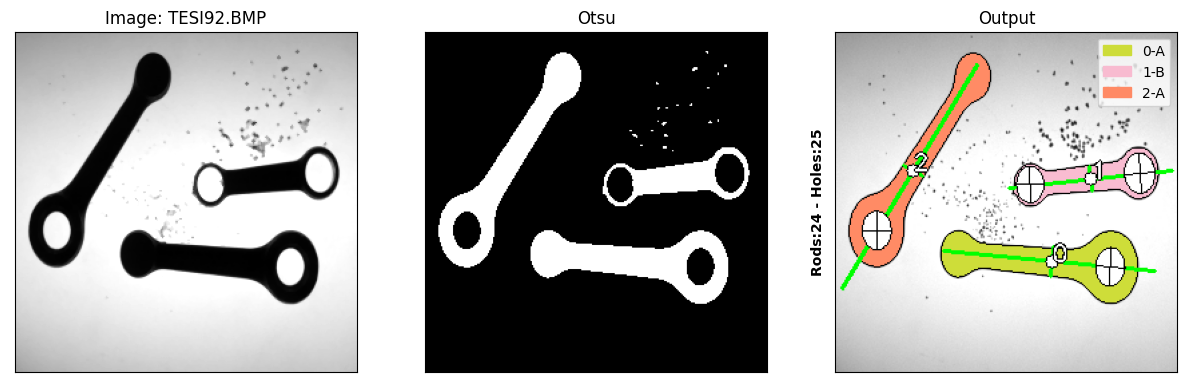

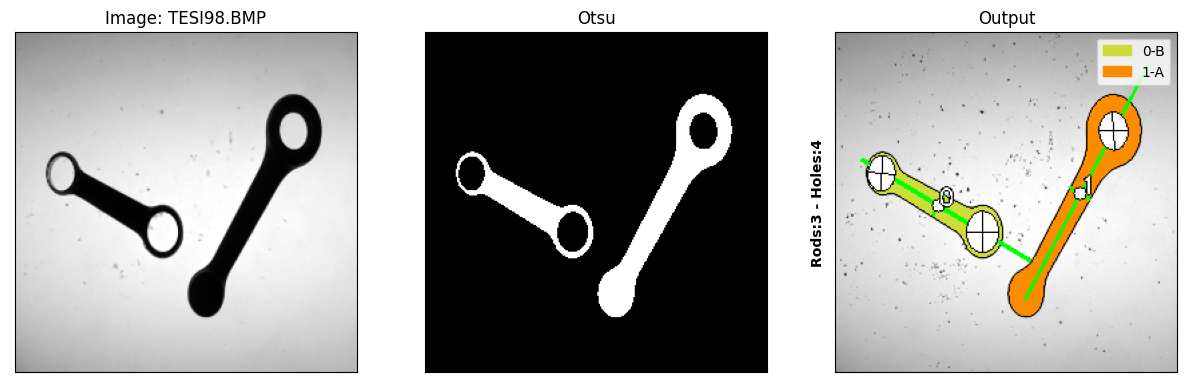

In [10]:
folder = 'inputs/2/'

images, b_images, ccs = [],[],[]
filenames = os.listdir(folder)
filenames = filenames[6:10]
rods_csv = []

for idx,filename in enumerate(filenames):    
    img = cv2.imread(os.path.join(folder,filename),0)
    output = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)

    colors = all_colors.copy()

    # Applying median blur to obtain a better binarization
    img = smoothing(img,3)
        
    # Thresholding with Otus's method Since the system should not 
    # require any change to work properly with lighting sources of different power
    _, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Finding outer and inner contours
    _ , contours, hierarchy = cv2.findContours(255-thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    rods_csv = component_analysis(filename, img, thresh, contours, hierarchy, output, rods_csv, 3) 

#### .csv

In [11]:
df = save_csv('task_2_c3.csv', rods_csv, header_csv)

df.iloc[:, 1:].head()

,id,type,MER,centre,width,length,centre_w,theta,color,hole_1_centre,hole_1_d_1,hole_1_d_2,hole_2_centre,hole_2_d_1,hole_2_d_2
0,0,B,"[(106, 208), (30, 105), (57, 85), (133, 187)]","(81, 143)",33.78,128.01,7.81,142.09,#7E57C2,"(114, 185)",27.39,21.11,"(54, 110)",30.74,23.40
1,1,A,"[(198, 197), (86, 71), (122, 39), (234, 165)]","(156, 109)",47.85,168.07,10.20,134.74,#CDDC39,"(121, 75)",28.55,22.89,[],0.00,0.00
2,0,A,"[(79, 203), (79, 149), (226, 149), (226, 203)]","(162, 172)",54.00,147.00,10.77,95.57,#CDDC39,"(206, 176)",28.93,21.96,[],0.00,0.00
3,1,B,"[(133, 131), (131, 92), (240, 85), (243, 124)]","(191, 110)",38.37,109.86,9.22,83.65,#F8BBD0,"(146, 114)",27.36,20.63,"(228, 106)",30.21,22.92
4,2,A,"[(37, 182), (-1, 160), (84, 4), (124, 25)]","(58, 104)",44.85,178.62,8.06,31.21,#FF8A65,"(31, 149)",29.11,21.65,[],0.00,0.00
